In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

#make plots inline using jupyter magic
%matplotlib inline

import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn import datasets, linear_model, metrics


import matplotlib as mpl
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.neighbors import KNeighborsClassifier
#Balanced RF Classifier
from imblearn.ensemble import BalancedRandomForestClassifier as BRF

from IPython.display import Markdown as md  #enable markdown within code cell
from IPython.display import display, Math, Latex

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import confusion_matrix
import time
import random
import scipy

from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, precision_recall_curve, make_scorer,f1_score
from sklearn.metrics import precision_recall_curve as PRC
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
from numpy.fft import fftn

## Homemade code imports
import metrics

data_dir = '/run/media/mnewlin/_userdata/uhnds/'
original_netflow_data_dir = data_dir + 'network/extracted/'
original_netflow_file = 'netflow_day-02'
fake_dir = '/run/media/mnewlin/_userdata/uhnds/network/converted/fake/'
real_dir = '/run/media/mnewlin/_userdata/uhnds/network/converted/real/'
real_file = 'netflow_day-02'
# Dataset dependent number of cols
N_COLS = 10
np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
"""
    Function to read in a single real sample from a given directory based
    on the desired length of the sample.
"""
def load_real_sample(sample_num, sample_length=100):

    data_dir = 'samples_{}/'.format(sample_length)
    if sample_length < 10000:
        if sample_num >= 10000:
            return -1
    elif sample_length < 100000:
        if sample_num >= 2000:
            return -1
    else:
        if sample_num >= 2000:
            return -1
        
    load_file = real_file + '_sample_{}.txt'.format(sample_num)
    filename = real_dir + data_dir + load_file
    df = pd.read_csv(filename, names=['Duration', 'SrcDevice', 
            'DstDevice', 'Protocol', 'SrcPort', 'DstPort', 'SrcPackets', 'DstPackets', 
            'SrcBytes', 'DstBytes'], sep=' ', dtype=np.float64)
    data = np.array(df)
    return data

In [3]:
"""
    Function to read in a single fake sample from a given directory based
    on the desired length of the sample.
"""
def load_fake_sample(sample_num, sample_length=100):
    data_dir = 'samples_{}/'.format(sample_length)
    if sample_length < 10000:
        if sample_num >= 10000:
            return -1
    elif sample_length < 100000:
        if sample_num >= 2000:
            return -1
    else:
        if sample_num >= 2000:
            return -1

    load_file = real_file + '_random_sample_{}.txt'.format(sample_num)
    filename = fake_dir + data_dir + load_file
    df = pd.read_csv(filename, names=['Duration', 'SrcDevice', 
            'DstDevice', 'Protocol', 'SrcPort', 'DstPort', 'SrcPackets', 'DstPackets', 
            'SrcBytes', 'DstBytes'], sep=' ', dtype=np.float64)
    data = np.array(df)
    return data

In [4]:
def load_n_samples(real=True, sample_length=100, num_samples=100, random_state=69):
    sample_set = np.array([])
    sample_range = 0
    if sample_length <= 1000:
        sample_range = 10000
    elif sample_length <= 10000:
        sample_range = 2000
    elif sample_length <= 100000:
        sample_range = 1160
    # Seed random samples for repeatability    
    random.seed(a=random_state)
    sample_list = random.sample(range(sample_range), num_samples)
    if real:
        for num in sample_list:
            data = load_real_sample(sample_length=sample_length, sample_num=num)
            sample_set = np.append(sample_set, data)
    else:
        for num in sample_list:
            data = load_fake_sample(sample_length=sample_length, sample_num=num)
            sample_set = np.append(sample_set, data)
    sample_set = np.reshape(sample_set, newshape=(num_samples, sample_length, N_COLS))
    return sample_set

In [5]:
def create_sample_mix(ratio, sample_length=100, num_samples=100, random_state=69):
    sample_range = 0
    if sample_length <= 1000:
        sample_range = 10000
    elif sample_length <= 10000:
        sample_range = 2000
    elif sample_length <= 100000:
        sample_range = 1160
    
    #mix_set = np.zeros((num_samples, sample_length, N_COLS))
    bound_val_real = np.around(((1-ratio)*num_samples), decimals=2)
    bound_val_fake = np.around((ratio)*num_samples, decimals=2)
    bound_val_real = int(bound_val_real) # How many real samples there should be
    bound_val_fake = int(bound_val_fake) # How many fake samples there should be
    
    real_data = load_n_samples(real=True, num_samples=num_samples, sample_length=sample_length, random_state=random_state) 
    fake_data = load_n_samples(real=True, num_samples=num_samples, sample_length=sample_length, random_state=random_state)
    real_section = real_data[:bound_val_real]
    fake_section = fake_data[:bound_val_real]
    mix_set = np.append(real_section, fake_section)
    mix_set = np.reshape(mix_set, newshape=(num_samples, sample_length, N_COLS))
    return mix_set

In [6]:
"""
    Takes in a set S of shape (num_samples, sample_length, N_COLS)
    and returns the PCA transform of each sample of shape (num_samples, N_COLS, N_COLS)
"""
def pca_transform_set(S):
    pca = PCA()
    num_samples = S.shape[0]
    sample_length = S.shape[1]
    s_pca = np.zeros((num_samples, sample_length, N_COLS))
    for x in range(num_samples):
        pca.fit(S[x])
        s_pca[x] = pca.components_
    return s_pca
    

## Time Efficiency

In [7]:
num_sample_list = [5*(n+1)*100 for n in range(20)]
num_sample_list.insert(0,100)
print(num_sample_list)
num_metrics = 11
num_sample_list = np.array(num_sample_list)
time_list = np.zeros((num_sample_list.size))
time_data_all = np.zeros((num_sample_list.size, num_metrics+1))
time_data_all[:,0] = num_sample_list
names = ['Euclidean', 'Manhattan', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd', 'fid']
cols = ['Runtime: ' + x for x in names]
cols.insert(0,'Number of Samples')


sample_length = 1000

[100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000]


In [8]:

for i in range(num_sample_list.size):
    sample_set_size = num_sample_list[i]
    S1 = load_n_samples(real=True, sample_length=sample_length, num_samples=sample_set_size, random_state=69)
    S2 = load_n_samples(real=True, sample_length=sample_length, num_samples=sample_set_size, random_state=42)
    G1 = load_n_samples(real=False, sample_length=sample_length, num_samples=sample_set_size, random_state=69)
    G2 = load_n_samples(real=False, sample_length=sample_length, num_samples=sample_set_size, random_state=42)
    
    _,t_diff = metrics.time_score_set(S1=S1, S2=S2, sample_length=sample_length, num_samples=sample_set_size, metric='lp', p=2, r=2)
    time_data_all[i,1] = t_diff
    _,t_diff = metrics.time_score_set(S1=S1, S2=S2, sample_length=sample_length, num_samples=sample_set_size, metric='lp', p=1, r=1)
    time_data_all[i,2] = t_diff
    _,t_diff = metrics.time_score_set(S1=S1, S2=S2, sample_length=sample_length, num_samples=sample_set_size, metric='lp', p=0.5, r=0.5)
    time_data_all[i,3] = t_diff
    _,t_diff = metrics.time_score_set(S1=S1, S2=S2, sample_length=sample_length, num_samples=sample_set_size, metric='lp', p=0.75, r=0.75)
    time_data_all[i,4] = t_diff
    _,t_diff = metrics.time_score_set(S1=S1, S2=S2, sample_length=sample_length, num_samples=sample_set_size, metric='cosine')
    time_data_all[i,5] = t_diff
    _,t_diff = metrics.time_score_set(S1=S1, S2=S2, sample_length=sample_length, num_samples=sample_set_size, metric='mahalanobis')
    time_data_all[i,6] = t_diff
    _,t_diff = metrics.time_score_set(S1=S1, S2=S2, sample_length=sample_length, num_samples=sample_set_size, metric='wasserstein')
    time_data_all[i,7] = t_diff
    _,t_diff = metrics.time_score_set(S1=S1, S2=S2, sample_length=sample_length, num_samples=sample_set_size, metric='entropy', standardized=False)
    time_data_all[i,8] = t_diff
    _,t_diff = metrics.time_score_set(S1=S1, S2=S2, sample_length=sample_length, num_samples=sample_set_size, metric='perplexity', standardized=False)
    time_data_all[i,9] = t_diff
    _,t_diff = metrics.time_score_set(S1=S1, S2=S2, sample_length=sample_length, num_samples=sample_set_size, metric='mmd', G1=G1, G2=G2)
    time_data_all[i,10] = t_diff
    
    pca = PCA()
    real_set_1 = np.zeros((sample_set_size, N_COLS, N_COLS))
    real_set_2 = np.zeros((sample_set_size, N_COLS, N_COLS))
    for x in range(sample_set_size):
        pca.fit(S1[x])
        real_set_1[x] = pca.components_
        
        pca.fit(S2[x])
        real_set_2[x] = pca.components_
    _,t_diff = metrics.time_score_set(S1=real_set_1, S2=real_set_2, sample_length=N_COLS, num_samples=sample_set_size, metric='fid')
    time_data_all[i,11] = t_diff
    print(sample_set_size)
time_eff_df = pd.DataFrame(data=time_data_all, columns=cols)
print("Finished")
display(time_eff_df.head())


100
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
Finished


,Number of Samples,Runtime: Euclidean,Runtime: Manhattan,Runtime: lp: p=r=0.5,Runtime: lp: p=r=0.75,Runtime: cosine,Runtime: mahalanobis,Runtime: wasserstein,Runtime: entropy,Runtime: perplexity,Runtime: mmd,Runtime: fid
0,100.0,0.042104,0.041378,0.093954,0.091635,0.089536,6.483543,0.0,0.643925,0.635140,8.592701,0.366710
1,500.0,0.211824,0.191801,0.412017,0.441723,0.429452,37.315845,0.0,3.171206,3.298879,46.080745,1.620127
2,1000.0,0.417698,0.414131,0.853007,0.876126,0.882164,71.234659,0.0,6.327049,6.315486,88.930807,3.303151
3,1500.0,0.592239,0.572699,1.272341,1.282392,1.258052,106.159819,0.0,9.341181,9.416537,133.281123,4.913507
4,2000.0,0.863315,0.772867,1.686367,1.722260,1.702844,140.371236,0.0,12.451819,12.395903,178.559145,6.679852


In [15]:
#outfile='/home/mnewlin/git/AFIT/Thesis/code/results/time_efficiency_results.csv'
#time_eff_df.to_csv(outfile)

wass_diffs = np.zeros((num_sample_list.size,))
for i in range(num_sample_list.size):
    sample_set_size = num_sample_list[i]
    S1 = load_n_samples(real=True, sample_length=sample_length, num_samples=sample_set_size, random_state=69)
    S2 = load_n_samples(real=True, sample_length=sample_length, num_samples=sample_set_size, random_state=42)
    _, wass_diff = metrics.time_score_set(S1=S1, S2=S2, sample_length=sample_length, num_samples=sample_set_size, metric='wasserstein')
    wass_diffs[i] = wass_diff
    print(sample_set_size, wass_diff)
print("Finished")


100 0.3096740245819092
500 1.2164556980133057
1000 2.453577995300293
1500 3.6714236736297607
2000 4.872739553451538
2500 6.1920082569122314
3000 7.315247297286987
3500 8.446828842163086
4000 9.519686937332153
4500 10.84392261505127
5000 11.98257565498352
5500 13.231746912002563
6000 14.595314979553223
6500 15.757635354995728
7000 17.01756000518799
7500 18.00524592399597
8000 19.447341918945312
8500 20.329765558242798
9000 22.04736089706421
9500 22.900646209716797
10000 24.028891563415527
Finished


'\nsample_set_size = 1000\nS1 = load_n_samples(real=True, sample_length=sample_length, num_samples=sample_set_size, random_state=69)\nS2 = load_n_samples(real=True, sample_length=sample_length, num_samples=sample_set_size, random_state=42)\nts = time.time()\nfor i in range(sample_set_size):\n    metrics.wasserstein_dist(S1[i], S2[i])\nte = time.time()\nt_diff = te-ts\nprint(t_diff)\n'

In [17]:
time_eff_df.at[:,'Runtime: wasserstein'] = wass_diffs
display(time_eff_df.head())

,Number of Samples,Runtime: Euclidean,Runtime: Manhattan,Runtime: lp: p=r=0.5,Runtime: lp: p=r=0.75,Runtime: cosine,Runtime: mahalanobis,Runtime: wasserstein,Runtime: entropy,Runtime: perplexity,Runtime: mmd,Runtime: fid
0,100.0,0.042104,0.041378,0.093954,0.091635,0.089536,6.483543,0.309674,0.643925,0.635140,8.592701,0.366710
1,500.0,0.211824,0.191801,0.412017,0.441723,0.429452,37.315845,1.216456,3.171206,3.298879,46.080745,1.620127
2,1000.0,0.417698,0.414131,0.853007,0.876126,0.882164,71.234659,2.453578,6.327049,6.315486,88.930807,3.303151
3,1500.0,0.592239,0.572699,1.272341,1.282392,1.258052,106.159819,3.671424,9.341181,9.416537,133.281123,4.913507
4,2000.0,0.863315,0.772867,1.686367,1.722260,1.702844,140.371236,4.872740,12.451819,12.395903,178.559145,6.679852


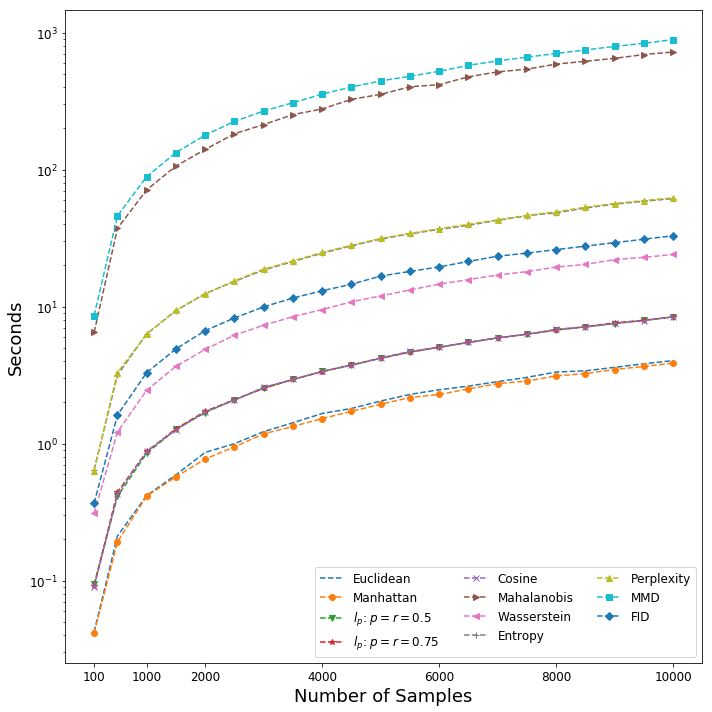

In [39]:
names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD', 'FID']
num_metrics = len(names)
markers = ['--', '--o', '--v', '--*','--x','-->','--<','--+','--^','--s','--D']
fig = plt.figure(figsize=(10,10))
for i in range(num_metrics):
    plt.semilogy(time_eff_df.loc[:,'Number of Samples'], time_eff_df.iloc[:,i+1], markers[i], label=names[i])
plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("Seconds", fontsize=18)
plt.xticks([100, 1000, 2000, 4000, 6000, 8000, 10000], fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, ncol=3)
plt.tight_layout()
plt.savefig('figures/efficiency/eps/time_efficiency.eps')
plt.savefig('figures/efficiency/png/time_efficiency.png')
plt.show()
    
outfile='/home/mnewlin/git/AFIT/Thesis/code/results/time_efficiency_results.csv'
time_eff_df.to_csv(outfile)

## Sample Efficiency

### Untransformed Data

In [7]:
num_metrics = 10
num_sample_list = [5*(n+1)*100 for n in range(10)]
num_sample_list.insert(0,100)
sample_efficiency_results = np.zeros((2, num_metrics, len(num_sample_list)))
counter = 0
for x in num_sample_list:
    # Load Sample Efficiency Results
    indir = '/run/media/mnewlin/_userdata/results_data/results/untrans/'
    real_data_untrans = pd.read_csv(indir+'real_data_exp_eff_{}.csv'.format(x)).drop(['Unnamed: 0','fid'], axis=1)
    #display(real_data_untrans.head())
    fake_data_untrans = pd.read_csv(indir+'fake_data_exp_eff_{}.csv'.format(x)).drop(['Unnamed: 0','fid'], axis=1)
    #display(fake_data_untrans.head())
    # Get mean KLD score for the 10 runs with x samples
    # Plot Number of samples vs mean KLD with standard deviation shading
    # Looking for KLD threshold of about 3
    titles = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
    labels = [r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', 
             'Metric values', 'Natural log metric values', 'Natural log Metric values', 'Natural log Metric values', 'Natural log Metric values', 'Metric values']
    subplots = []
    y_label = 'Count'
    binsize = 100
    alpha_blue = 0.8
    alpha_red = 0.6
    n_repeats = 10
    real_data = real_data_untrans
    fake_data = fake_data_untrans
    
    sample_length = x
    real_dists = np.zeros((n_repeats,binsize-1,num_metrics))
    fake_dists = np.zeros((n_repeats,binsize-1,num_metrics))

    for i in range(n_repeats):

        fig = plt.figure(figsize=(15,20))

        grid_x = 5
        grid_y = 2
        grid = mpl.gridspec.GridSpec(grid_x, grid_y)
        count = 0

        r = np.zeros((num_metrics, binsize-1))
        f = np.zeros((num_metrics, binsize-1))
        rr = 0
        rf = 0
        for j in range(grid_x):
            for k in range(grid_y):
                ax1 = plt.subplot(grid[j,k])
                if 'Natural' in labels[count]:
                    rr = np.log(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                elif '10' in labels[count]:
                    rr = np.log10(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log10(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                else:
                    rr = real_data.iloc[i*sample_length:(i+1)*sample_length, count]
                    rf = fake_data.iloc[i*sample_length:(i+1)*sample_length, count]
                best_bins_min = np.minimum(rr.min(), rf.min()) 
                best_bins_max = np.maximum(rr.max(), rf.max()) 
                bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
                real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real')
                fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake')
                r[count] = real_hist_data[0]
                f[count] = fake_hist_data[0]
                ax1.set_xlabel(labels[count], fontsize=16)
                ax1.set_ylabel(y_label, fontsize=16)
                ax1.set_title(titles[count], fontsize=16)
                ax1.legend(fontsize=16)
                count += 1
        rd = np.zeros((binsize-1, num_metrics))
        fd = np.zeros((binsize-1, num_metrics))
        for j in range(num_metrics):
            rd[:,j] = r[j]
            fd[:,j] = f[j]

        real_dists[i] = rd
        fake_dists[i] = fd 
        plt.close()
    names = ['Euclidean', 'Manhattan', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd']
    cols = []
    for i in range(n_repeats):
        cols.append('Run {}'.format(i+1))
    eps = 1e-5
    #KLD_data_all = np.zeros((num_metrics, n_repeats))
    real_data = pd.DataFrame(data=np.mean(real_dists, axis=0), columns=names)
    fake_data = pd.DataFrame(data=np.mean(fake_dists, axis=0), columns=names)
    euc_KLD = metrics.KL(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']), eps=eps)
    man_KLD = metrics.KL(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']), eps=eps)
    lp1_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']), eps=eps)
    lp2_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']), eps=eps)
    cos_KLD = metrics.KL(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']), eps=eps)
    mah_KLD = metrics.KL(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']), eps=eps)
    wass_KLD = metrics.KL(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']), eps=eps)
    ent_KLD = metrics.KL(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']), eps=eps)
    perp_KLD = metrics.KL(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']), eps=eps)
    mmd_KLD = metrics.KL(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']), eps=eps)

    kld_data = np.array([euc_KLD, man_KLD, lp1_KLD, lp2_KLD, cos_KLD, mah_KLD, wass_KLD, ent_KLD, perp_KLD, mmd_KLD])
    sample_efficiency_results[0,:,counter] = kld_data
    #sample_efficiency_results[1,:,counter] = KLD_data_untrans.loc[:,'Std. Dev.']
    counter += 1    
    #KLD_data_all[:,i] = kld_data.T
    

In [8]:
sample_eff_res_mean_df = pd.DataFrame(data=sample_efficiency_results[0], index=names, columns=num_sample_list)
display(sample_eff_res_mean_df)
#sample_eff_res_std_df = pd.DataFrame(data=sample_efficiency_results[1], index=names, columns=num_sample_list)
#display(sample_eff_res_std_df)

,100,500,1000,1500,2000,2500,3000,3500,4000,4500,5000
Euclidean,0.330738,0.221289,0.204777,0.197157,0.197302,0.194948,0.191262,0.193742,0.192502,0.193077,0.193834
Manhattan,0.250816,0.214639,0.201790,0.196665,0.193230,0.193356,0.189051,0.189738,0.188915,0.196254,0.192728
lp: p=r=0.5,0.320453,0.217352,0.205967,0.192431,0.185527,0.181550,0.188755,0.182208,0.189538,0.196898,0.196420
lp: p=r=0.75,0.323035,0.234168,0.218153,0.206785,0.204858,0.205563,0.206195,0.206834,0.207589,0.211830,0.210266
cosine,2.353748,1.729965,1.624510,1.572296,1.557598,1.604317,1.654681,1.640220,1.646155,1.635329,1.653829
mahalanobis,0.496372,0.452060,0.435394,0.377912,0.376656,0.348015,0.313901,0.314253,0.300740,0.300154,0.288244
wasserstein,0.776848,0.433762,0.405951,0.410628,0.408395,0.415424,0.410430,0.410334,0.409028,0.397878,0.394216
entropy,6.876895,7.013467,6.972715,6.781306,6.921596,6.939460,6.913289,6.801669,6.807380,6.837387,6.703731
perplexity,4.879222,4.904802,4.937692,5.003759,5.016044,5.030525,4.939177,4.934685,5.033303,5.239768,5.177500
mmd,0.378235,0.139506,0.124931,0.107440,0.112522,0.099076,0.082910,0.084408,0.076743,0.074448,0.065468


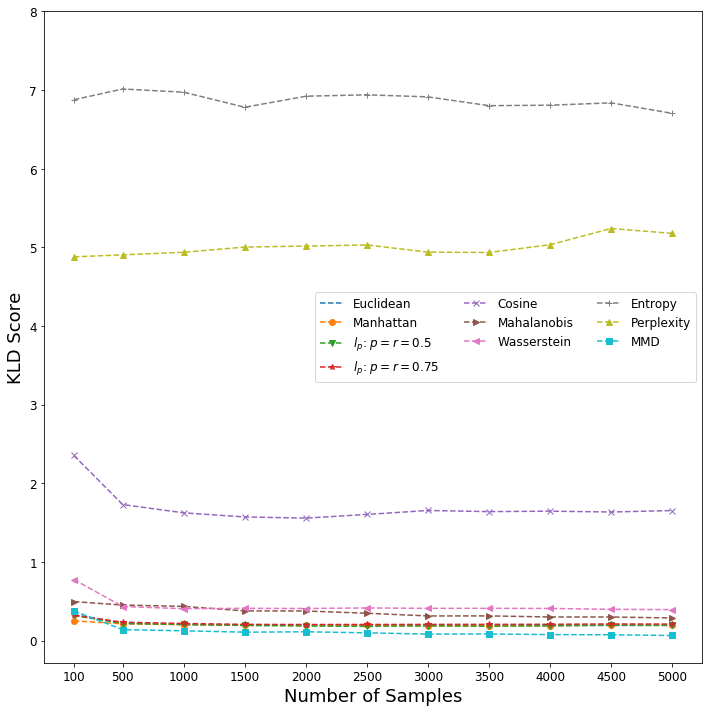

In [9]:
outdir='/home/mnewlin/git/AFIT/Thesis/code/figures/efficiency/'
markers = ['--', '--o', '--v', '--*','--x','-->','--<','--+','--^','--s','--D']
names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
#colors = ['b', 'g', 'r', 'y', 'c', 'm', 'k', ]
max_val = np.int(np.ceil(sample_eff_res_mean_df.max().max()))
"""
fig = plt.figure(figsize=(10,10))
for i in range(num_metrics):
    y_val = sample_eff_res_mean_df.iloc[i]
    sigma = sample_eff_res_std_df.iloc[i]
    plt.plot(num_sample_list, y_val, markers[i], label=sample_eff_res_mean_df.index[i])
    plt.fill_between(num_sample_list, y_val+sigma, y_val-sigma, alpha=0.1, color='b' )

plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("KLD Score", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(np.linspace(0,9, 10), fontsize=12)
plt.legend(fontsize=12, ncol=3)

plt.tight_layout()
plt.savefig(outdir + 'eps/sample_efficiency_untrans_std.pdf')
plt.savefig(outdir + 'png/sample_efficiency_untrans_std.png')
plt.show()
"""
fig = plt.figure(figsize=(10,10))
for i in range(num_metrics):
    y_val = sample_eff_res_mean_df.iloc[i]
    #sigma = sample_eff_res_std_df.iloc[i]
    plt.plot(num_sample_list, y_val, markers[i], label=names[i])
    #plt.fill_between(num_sample_list, y_val+sigma, y_val-sigma, alpha=0.1, color='b' )

plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("KLD Score", fontsize=18)
plt.xticks(num_sample_list, fontsize=12)
plt.yticks(np.linspace(0,max_val, max_val+1), fontsize=12)
plt.legend(fontsize=12, ncol=3)

plt.tight_layout()
plt.savefig(outdir + 'eps/sample_efficiency_untrans_no_std.pdf')
plt.savefig(outdir + 'png/sample_efficiency_untrans_no_std.png')
plt.show()

## Square Root

In [10]:
num_metrics = 10
num_sample_list = [5*(n+1)*100 for n in range(10)]
num_sample_list.insert(0,100)
sample_efficiency_results = np.zeros((2, num_metrics, len(num_sample_list)))
counter = 0
names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
for x in num_sample_list:
    # Load Sample Efficiency Results
    indir = '/run/media/mnewlin/_userdata/results_data/results/sqrt/'
    real_data_sqrt = pd.read_csv(indir+'real_data_exp_eff_{}.csv'.format(x)).drop(['Unnamed: 0','fid'], axis=1)
    #display(real_data_untrans.head())
    fake_data_sqrt = pd.read_csv(indir+'fake_data_exp_eff_{}.csv'.format(x)).drop(['Unnamed: 0','fid'], axis=1)
    #display(fake_data_untrans.head())
    # Get mean KLD score for the 10 runs with x samples
    # Plot Number of samples vs mean KLD with standard deviation shading
    # Looking for KLD threshold of about 3
    titles = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
    labels = [r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', 
             'Metric values', 'Natural log metric values', 'Natural log Metric values', 'Natural log Metric values', 'Natural log Metric values', 'Metric values']
    subplots = []
    y_label = 'Count'
    binsize = 100
    alpha_blue = 0.8
    alpha_red = 0.6
    n_repeats = 10
    real_data = real_data_sqrt
    fake_data = fake_data_sqrt
    
    sample_length = x
    real_dists = np.zeros((n_repeats,binsize-1,num_metrics))
    fake_dists = np.zeros((n_repeats,binsize-1,num_metrics))

    for i in range(n_repeats):

        fig = plt.figure(figsize=(15,20))

        grid_x = 5
        grid_y = 2
        grid = mpl.gridspec.GridSpec(grid_x, grid_y)
        count = 0

        r = np.zeros((num_metrics, binsize-1))
        f = np.zeros((num_metrics, binsize-1))
        rr = 0
        rf = 0
        for j in range(grid_x):
            for k in range(grid_y):
                ax1 = plt.subplot(grid[j,k])
                if 'Natural' in labels[count]:
                    rr = np.log(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                elif '10' in labels[count]:
                    rr = np.log10(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log10(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                else:
                    rr = real_data.iloc[i*sample_length:(i+1)*sample_length, count]
                    rf = fake_data.iloc[i*sample_length:(i+1)*sample_length, count]
                best_bins_min = np.minimum(rr.min(), rf.min()) 
                best_bins_max = np.maximum(rr.max(), rf.max()) 
                bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
                real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real')
                fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake')
                r[count] = real_hist_data[0]
                f[count] = fake_hist_data[0]
                ax1.set_xlabel(labels[count], fontsize=16)
                ax1.set_ylabel(y_label, fontsize=16)
                ax1.set_title(titles[count], fontsize=16)
                ax1.legend(fontsize=16)
                count += 1
        rd = np.zeros((binsize-1, num_metrics))
        fd = np.zeros((binsize-1, num_metrics))
        for j in range(num_metrics):
            rd[:,j] = r[j]
            fd[:,j] = f[j]

        real_dists[i] = rd
        fake_dists[i] = fd 
        plt.close()
    names = ['Euclidean', 'Manhattan', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd']
    cols = []
    for i in range(n_repeats):
        cols.append('Run {}'.format(i+1))
    eps = 1e-5
    real_data = pd.DataFrame(data=np.mean(real_dists, axis=0), columns=names)
    fake_data = pd.DataFrame(data=np.mean(fake_dists, axis=0), columns=names)
    euc_KLD = metrics.KL(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']), eps=eps)
    man_KLD = metrics.KL(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']), eps=eps)
    lp1_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']), eps=eps)
    lp2_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']), eps=eps)
    cos_KLD = metrics.KL(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']), eps=eps)
    mah_KLD = metrics.KL(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']), eps=eps)
    wass_KLD = metrics.KL(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']), eps=eps)
    ent_KLD = metrics.KL(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']), eps=eps)
    perp_KLD = metrics.KL(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']), eps=eps)
    mmd_KLD = metrics.KL(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']), eps=eps)

    kld_data = np.array([man_KLD, euc_KLD, lp1_KLD, lp2_KLD, cos_KLD, mah_KLD, wass_KLD, ent_KLD, perp_KLD, mmd_KLD])
    sample_efficiency_results[0,:,counter] = kld_data
    #sample_efficiency_results[1,:,counter] = KLD_data_untrans.loc[:,'Std. Dev.']
    counter += 1
    

In [11]:
sample_eff_res_mean_df = pd.DataFrame(data=sample_efficiency_results[0], index=names, columns=num_sample_list)
display(sample_eff_res_mean_df)


,100,500,1000,1500,2000,2500,3000,3500,4000,4500,5000
Euclidean,0.286444,0.209893,0.188610,0.183329,0.181810,0.179606,0.178948,0.180042,0.181296,0.186073,0.185084
Manhattan,0.316963,0.195288,0.179410,0.157291,0.151453,0.142382,0.151321,0.145090,0.154332,0.160467,0.162531
lp: p=r=0.5,0.333409,0.172282,0.149497,0.144756,0.160016,0.140798,0.139975,0.150677,0.155982,0.178666,0.171472
lp: p=r=0.75,0.378875,0.178601,0.158468,0.152182,0.156954,0.131010,0.137496,0.155426,0.160201,0.158442,0.157479
cosine,1.128429,0.871149,0.786047,0.764460,0.719897,0.734849,0.770793,0.789269,0.796686,0.793471,0.802304
mahalanobis,1.058204,0.710513,0.600842,0.637231,0.585846,0.614440,0.568871,0.586052,0.520220,0.577585,0.530486
wasserstein,0.565489,0.381067,0.355610,0.381118,0.392971,0.394144,0.416887,0.396489,0.411827,0.399477,0.389296
entropy,2.628473,2.694778,2.640680,2.613804,2.624881,2.604410,2.585038,2.653224,2.634571,2.653525,2.630995
perplexity,2.234848,1.811164,1.645766,1.695664,1.662180,1.521163,1.489515,1.590856,1.556106,1.499198,1.493513
mmd,0.295849,0.088863,0.082999,0.071189,0.064226,0.057917,0.041914,0.041860,0.036546,0.031298,0.029377


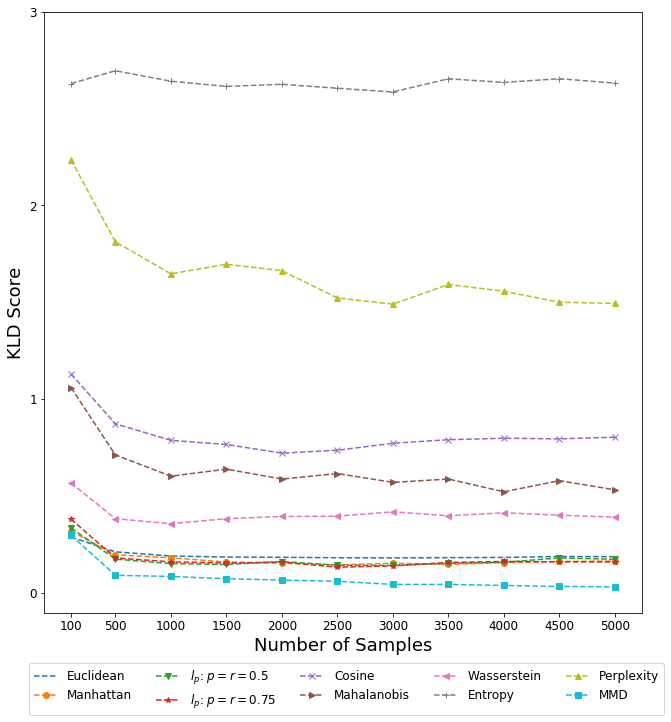

In [12]:
outdir='/home/mnewlin/git/AFIT/Thesis/code/figures/efficiency/'
markers = ['--', '--o', '--v', '--*','--x','-->','--<','--+','--^','--s','--D']
names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
#colors = ['b', 'g', 'r', 'y', 'c', 'm', 'k', ]
max_val = np.int(np.ceil(sample_eff_res_mean_df.max().max()))
"""
fig = plt.figure(figsize=(10,10))
for i in range(num_metrics):
    y_val = sample_eff_res_mean_df.iloc[i]
    sigma = sample_eff_res_std_df.iloc[i]
    plt.plot(num_sample_list, y_val, markers[i], label=sample_eff_res_mean_df.index[i])
    plt.fill_between(num_sample_list, y_val+sigma, y_val-sigma, alpha=0.1, color='b' )

plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("KLD Score", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(np.linspace(0,6, 7), fontsize=12)
plt.legend(fontsize=12, ncol=3)

plt.tight_layout()
plt.savefig(outdir + 'eps/sample_efficiency_sqrt_std.pdf')
plt.savefig(outdir + 'png/sample_efficiency_sqrt_std.png')
plt.show()
"""
fig = plt.figure(figsize=(10,10))
for i in range(num_metrics):
    y_val = sample_eff_res_mean_df.iloc[i]
    plt.plot(num_sample_list, y_val, markers[i], label=names[i])
    #plt.fill_between(num_sample_list, y_val+sigma, y_val-sigma, alpha=0.1, color='b' )

plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("KLD Score", fontsize=18)
plt.xticks(num_sample_list, fontsize=12)
plt.yticks(np.linspace(0,max_val, max_val+1), fontsize=12)
plt.legend(loc=(-0.025,-.17), fontsize=12, ncol=5)

plt.tight_layout()
plt.savefig(outdir + 'eps/sample_efficiency_sqrt_no_std.pdf')
plt.savefig(outdir + 'png/sample_efficiency_sqrt_no_std.png')
plt.show()

## Log

In [13]:
num_metrics = 10
num_sample_list = [5*(n+1)*100 for n in range(10)]
num_sample_list.insert(0,100)
sample_efficiency_results = np.zeros((2, num_metrics, len(num_sample_list)))
counter = 0
names = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
for x in num_sample_list:
    # Load Sample Efficiency Results
    indir = '/run/media/mnewlin/_userdata/results_data/results/log/'
    real_data_log = pd.read_csv(indir+'real_data_exp_eff_{}.csv'.format(x)).drop(['Unnamed: 0','fid'], axis=1)
    #display(real_data_untrans.head())
    fake_data_log = pd.read_csv(indir+'fake_data_exp_eff_{}.csv'.format(x)).drop(['Unnamed: 0','fid'], axis=1)
    #display(fake_data_untrans.head())
    # Get mean KLD score for the 10 runs with x samples
    # Plot Number of samples vs mean KLD with standard deviation shading
    # Looking for KLD threshold of about 3
    titles = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
    labels = [r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', 
             'Metric values', 'Natural log metric values', 'Natural log Metric values', 'Natural log Metric values', 'Natural log Metric values', 'Metric values']
    subplots = []
    y_label = 'Count'
    binsize = 100
    alpha_blue = 0.8
    alpha_red = 0.6
    n_repeats = 10
    real_data = real_data_log
    fake_data = fake_data_log
    
    sample_length = x
    real_dists = np.zeros((n_repeats,binsize-1,num_metrics))
    fake_dists = np.zeros((n_repeats,binsize-1,num_metrics))

    for i in range(n_repeats):

        fig = plt.figure(figsize=(15,20))

        grid_x = 5
        grid_y = 2
        grid = mpl.gridspec.GridSpec(grid_x, grid_y)
        count = 0

        r = np.zeros((num_metrics, binsize-1))
        f = np.zeros((num_metrics, binsize-1))
        rr = 0
        rf = 0
        for j in range(grid_x):
            for k in range(grid_y):
                ax1 = plt.subplot(grid[j,k])
                if 'Natural' in labels[count]:
                    rr = np.log(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                elif '10' in labels[count]:
                    rr = np.log10(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log10(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                else:
                    rr = real_data.iloc[i*sample_length:(i+1)*sample_length, count]
                    rf = fake_data.iloc[i*sample_length:(i+1)*sample_length, count]
                best_bins_min = np.minimum(rr.min(), rf.min()) 
                best_bins_max = np.maximum(rr.max(), rf.max()) 
                bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
                real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real')
                fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake')
                r[count] = real_hist_data[0]
                f[count] = fake_hist_data[0]
                ax1.set_xlabel(labels[count], fontsize=16)
                ax1.set_ylabel(y_label, fontsize=16)
                ax1.set_title(titles[count], fontsize=16)
                ax1.legend(fontsize=16)
                count += 1
        rd = np.zeros((binsize-1, num_metrics))
        fd = np.zeros((binsize-1, num_metrics))
        for j in range(num_metrics):
            rd[:,j] = r[j]
            fd[:,j] = f[j]

        real_dists[i] = rd
        fake_dists[i] = fd 
        plt.close()
    names = ['Euclidean', 'Manhattan', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd']
    cols = []
    for i in range(n_repeats):
        cols.append('Run {}'.format(i+1))
    eps = 1e-5
    real_data = pd.DataFrame(data=np.mean(real_dists, axis=0), columns=names)
    fake_data = pd.DataFrame(data=np.mean(fake_dists, axis=0), columns=names)
    euc_KLD = metrics.KL(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']), eps=eps)
    man_KLD = metrics.KL(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']), eps=eps)
    lp1_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']), eps=eps)
    lp2_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']), eps=eps)
    cos_KLD = metrics.KL(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']), eps=eps)
    mah_KLD = metrics.KL(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']), eps=eps)
    wass_KLD = metrics.KL(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']), eps=eps)
    ent_KLD = metrics.KL(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']), eps=eps)
    perp_KLD = metrics.KL(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']), eps=eps)
    mmd_KLD = metrics.KL(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']), eps=eps)

    kld_data = np.array([man_KLD, euc_KLD, lp1_KLD, lp2_KLD, cos_KLD, mah_KLD, wass_KLD, ent_KLD, perp_KLD, mmd_KLD])
    sample_efficiency_results[0,:,counter] = kld_data
    #sample_efficiency_results[1,:,counter] = KLD_data_untrans.loc[:,'Std. Dev.']
    counter += 1
    

In [14]:
sample_eff_res_mean_df = pd.DataFrame(data=sample_efficiency_results[0], index=names, columns=num_sample_list)
display(sample_eff_res_mean_df)


,100,500,1000,1500,2000,2500,3000,3500,4000,4500,5000
Euclidean,0.370713,0.166799,0.177939,0.131824,0.172351,0.121375,0.147773,0.138651,0.108382,0.227087,0.210828
Manhattan,0.358505,0.170447,0.147199,0.115574,0.115770,0.131851,0.134165,0.105498,0.078093,0.167594,0.160751
lp: p=r=0.5,0.537437,0.277542,0.273571,0.287743,0.350479,0.449118,0.466556,0.493951,0.368307,0.451324,0.465194
lp: p=r=0.75,0.371202,0.151949,0.142413,0.122272,0.169679,0.173779,0.218066,0.153234,0.131590,0.209198,0.222947
cosine,0.416255,0.202221,0.175925,0.152701,0.168598,0.167862,0.188594,0.224312,0.225114,0.224919,0.223938
mahalanobis,1.456926,0.845387,0.676842,0.823396,0.677321,0.870830,0.854458,1.033585,0.881302,0.889900,0.868415
wasserstein,0.560380,0.290898,0.304709,0.299145,0.345999,0.346153,0.328040,0.328503,0.311450,0.334085,0.325318
entropy,0.675715,0.558421,0.510738,0.493712,0.539131,0.474407,0.497393,0.544545,0.496670,0.476517,0.457477
perplexity,0.412316,0.237840,0.217807,0.185810,0.176264,0.156491,0.148546,0.159442,0.150768,0.166496,0.183187
mmd,0.361002,0.102077,0.085817,0.073498,0.068781,0.056793,0.052765,0.048888,0.047864,0.047512,0.045773


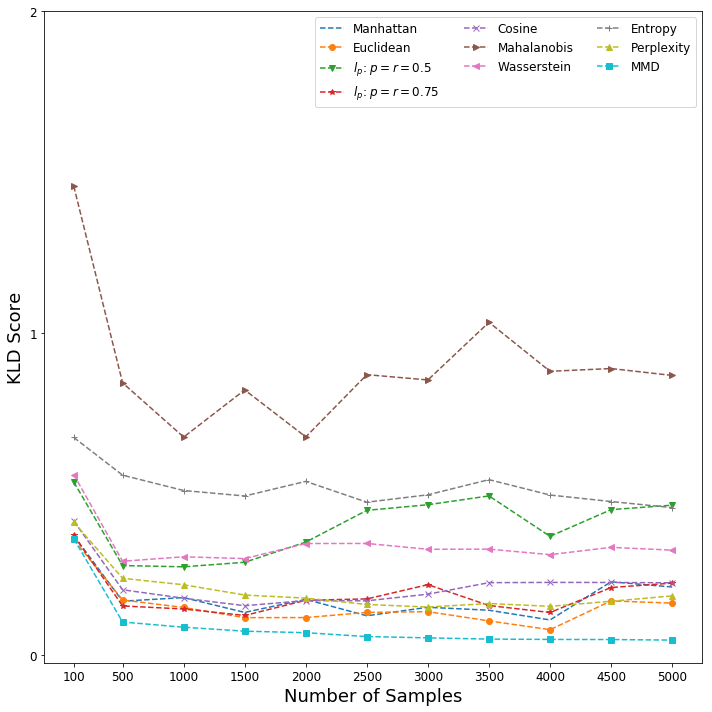

In [15]:
outdir='/home/mnewlin/git/AFIT/Thesis/code/figures/efficiency/'
markers = ['--', '--o', '--v', '--*','--x','-->','--<','--+','--^','--s','--D']
names = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
#colors = ['b', 'g', 'r', 'y', 'c', 'm', 'k', ]
max_val = np.int(np.ceil(sample_eff_res_mean_df.max().max()))
"""
fig = plt.figure(figsize=(10,10))
for i in range(num_metrics):
    y_val = sample_eff_res_mean_df.iloc[i]
    sigma = sample_eff_res_std_df.iloc[i]
    plt.plot(num_sample_list, y_val, markers[i], label=sample_eff_res_mean_df.index[i])
    plt.fill_between(num_sample_list, y_val+sigma, y_val-sigma, alpha=0.1, color='b' )

max_val = np.int(np.ceil(sample_eff_res_mean_df.max().max()))
plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("KLD Score", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(np.linspace(0,max_val, max_val+1), fontsize=12)
plt.legend(fontsize=12, ncol=3)

plt.tight_layout()
plt.savefig(outdir + 'eps/sample_efficiency_log_std.pdf')
plt.savefig(outdir + 'png/sample_efficiency_log_std.png')
plt.show()
"""
fig = plt.figure(figsize=(10,10))
for i in range(num_metrics):
    y_val = sample_eff_res_mean_df.iloc[i]
    #sigma = sample_eff_res_std_df.iloc[i]
    plt.plot(num_sample_list, y_val, markers[i], label=names[i])
    #plt.fill_between(num_sample_list, y_val+sigma, y_val-sigma, alpha=0.1, color='b' )

plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("KLD Score", fontsize=18)
plt.xticks(num_sample_list, fontsize=12)
plt.yticks(np.linspace(0,max_val, max_val+1), fontsize=12)
plt.legend(fontsize=12, ncol=3)

plt.tight_layout()
plt.savefig(outdir + 'eps/sample_efficiency_log_no_std.pdf')
plt.savefig(outdir + 'png/sample_efficiency_log_no_std.png')
plt.show()

## PCA

In [16]:
num_metrics = 11
num_sample_list = [5*(n+1)*100 for n in range(10)]
num_sample_list.insert(0,100)
sample_efficiency_results = np.zeros((2, num_metrics, len(num_sample_list)))
counter = 0
names = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD', 'FID']
for x in num_sample_list:
    # Load Sample Efficiency Results
    indir = '/run/media/mnewlin/_userdata/results_data/results/pca/'
    real_data_pca = pd.read_csv(indir+'real_data_exp_eff_{}.csv'.format(x)).drop(['Unnamed: 0'], axis=1)
    #display(real_data_untrans.head())
    fake_data_pca = pd.read_csv(indir+'fake_data_exp_eff_{}.csv'.format(x)).drop(['Unnamed: 0'], axis=1)
    #display(fake_data_untrans.head())
    # Get mean KLD score for the 10 runs with x samples
    # Plot Number of samples vs mean KLD with standard deviation shading
    # Looking for KLD threshold of about 3
    titles = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD', 'FID']
    labels = [r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', 
             'Metric values', 'Natural log metric values', 'Natural log Metric values', 'Natural log Metric values', 'Natural log Metric values', 
              'Metric values', 'Metric values']
    subplots = []
    y_label = 'Count'
    binsize = 100
    alpha_blue = 0.8
    alpha_red = 0.6
    n_repeats = 10
    real_data = real_data_pca
    fake_data = fake_data_pca
    
    sample_length = x
    real_dists = np.zeros((n_repeats,binsize-1,num_metrics))
    fake_dists = np.zeros((n_repeats,binsize-1,num_metrics))

    for i in range(n_repeats):

        fig = plt.figure(figsize=(15,20))

        grid_x = 4
        grid_y = 3
        grid = mpl.gridspec.GridSpec(grid_x, grid_y)
        count = 0

        r = np.zeros((num_metrics, binsize-1))
        f = np.zeros((num_metrics, binsize-1))
        rr = 0
        rf = 0
        for j in range(grid_x):
            for k in range(grid_y):
                ax1 = plt.subplot(grid[j,k])
                if 'Natural' in labels[count]:
                    rr = np.log(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                elif '10' in labels[count]:
                    rr = np.log10(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log10(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                else:
                    rr = real_data.iloc[i*sample_length:(i+1)*sample_length, count]
                    rf = fake_data.iloc[i*sample_length:(i+1)*sample_length, count]
                best_bins_min = np.minimum(rr.min(), rf.min()) 
                best_bins_max = np.maximum(rr.max(), rf.max()) 
                bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
                real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real')
                fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake')
                r[count] = real_hist_data[0]
                f[count] = fake_hist_data[0]
                ax1.set_xlabel(labels[count], fontsize=16)
                ax1.set_ylabel(y_label, fontsize=16)
                ax1.set_title(titles[count], fontsize=16)
                ax1.legend(fontsize=16)
                count += 1
                if count >= num_metrics:
                    break
        rd = np.zeros((binsize-1, num_metrics))
        fd = np.zeros((binsize-1, num_metrics))
        for j in range(num_metrics):
            rd[:,j] = r[j]
            fd[:,j] = f[j]

        real_dists[i] = rd
        fake_dists[i] = fd
        plt.close()
        
    names = ['Euclidean', 'Manhattan', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd', 'fid']
    cols = []
    for i in range(n_repeats):
        cols.append('Run {}'.format(i+1))
    eps = 1e-5    
    real_data = pd.DataFrame(data=np.mean(real_dists, axis=0), columns=names)
    fake_data = pd.DataFrame(data=np.mean(fake_dists, axis=0), columns=names)
    euc_KLD = metrics.KL(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']), eps=eps)
    man_KLD = metrics.KL(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']), eps=eps)
    lp1_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']), eps=eps)
    lp2_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']), eps=eps)
    cos_KLD = metrics.KL(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']), eps=eps)
    mah_KLD = metrics.KL(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']), eps=eps)
    wass_KLD = metrics.KL(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']), eps=eps)
    ent_KLD = metrics.KL(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']), eps=eps)
    perp_KLD = metrics.KL(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']), eps=eps)
    mmd_KLD = metrics.KL(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']), eps=eps)
    fid_KLD = metrics.KL(real_data.loc[:,'fid']/np.sum(real_data.loc[:,'fid']), fake_data.loc[:,'fid']/np.sum(fake_data.loc[:,'fid']), eps=eps)
    
    kld_data = np.array([euc_KLD, man_KLD, lp1_KLD, lp2_KLD, cos_KLD, mah_KLD, wass_KLD, ent_KLD, perp_KLD, mmd_KLD, fid_KLD])
    sample_efficiency_results[0,:,counter] = kld_data
    #sample_efficiency_results[1,:,counter] = KLD_data_untrans.loc[:,'Std. Dev.']
    counter += 1


In [17]:
sample_eff_res_mean_df = pd.DataFrame(data=sample_efficiency_results[0], index=names, columns=num_sample_list)
display(sample_eff_res_mean_df)


,100,500,1000,1500,2000,2500,3000,3500,4000,4500,5000
Euclidean,4.218029,4.118623,3.759821,3.522950,3.446079,3.339633,3.107016,3.093490,2.861959,2.907261,2.757045
Manhattan,0.761430,0.555724,0.448876,0.447616,0.438202,0.400013,0.349023,0.355651,0.312347,0.307891,0.272726
lp: p=r=0.5,6.793274,6.118384,5.912270,5.571033,5.540451,5.127934,4.999691,5.097849,4.815180,5.287773,5.317016
lp: p=r=0.75,5.676028,5.331500,5.110239,4.772016,4.667051,4.466959,4.285359,4.276707,4.058035,4.418695,4.286952
cosine,0.910151,0.770263,0.701745,0.718942,0.700702,0.711545,0.717256,0.709536,0.707703,0.723487,0.734398
mahalanobis,0.633773,0.452524,0.446152,0.455652,0.391615,0.458010,0.378263,0.350269,0.342489,0.320024,0.298067
wasserstein,5.917224,4.013684,3.878306,3.854917,3.905086,3.887848,4.205684,4.238036,4.564106,4.442007,4.729650
entropy,4.504509,3.915345,3.630607,3.658445,3.602502,3.661230,3.652461,3.586516,3.619838,3.621944,3.640706
perplexity,3.822408,3.123419,3.001409,3.051261,3.022085,3.028853,3.047952,2.980229,2.953839,3.010133,3.011179
mmd,1.433051,0.837399,0.754702,0.739337,0.742921,0.774232,0.779741,0.740066,0.770883,0.848606,0.899037


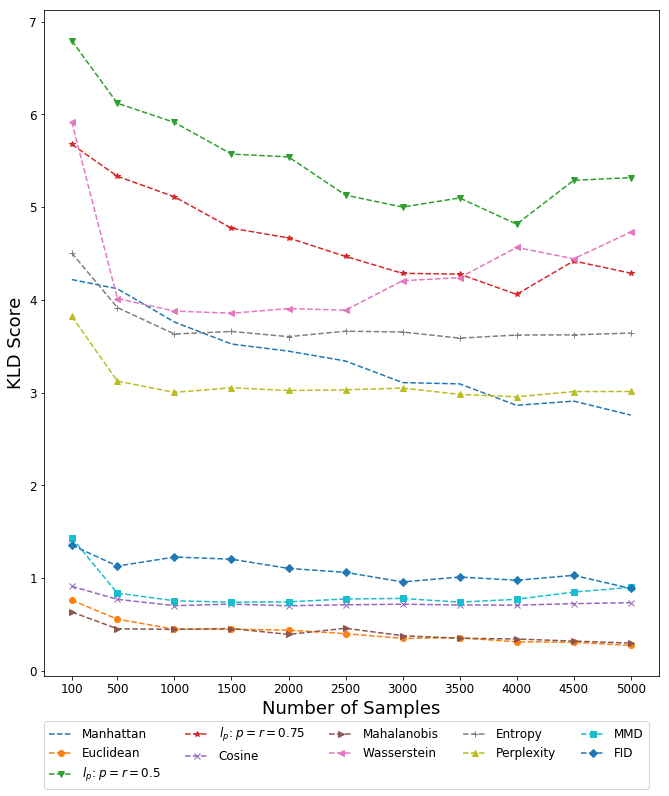

In [18]:
outdir='/home/mnewlin/git/AFIT/Thesis/code/figures/efficiency/'
markers = ['--', '--o', '--v', '--*','--x','-->','--<','--+','--^','--s','--D']
#colors = ['b', 'g', 'r', 'y', 'c', 'm', 'k', ]
max_val = np.int(np.ceil(sample_eff_res_mean_df.max().max()))
names = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD', 'FID']
"""
fig = plt.figure(figsize=(10,11))
for i in range(num_metrics):
    y_val = sample_eff_res_mean_df.iloc[i]
    sigma = sample_eff_res_std_df.iloc[i]
    plt.plot(num_sample_list, y_val, markers[i], label=sample_eff_res_mean_df.index[i])
    plt.fill_between(num_sample_list, y_val+sigma, y_val-sigma, alpha=0.1, color='b' )


plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("KLD Score", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(np.linspace(0,max_val, max_val+1), fontsize=12)
plt.legend(loc=(0,-.17), fontsize=12, ncol=5)

plt.tight_layout()
plt.savefig(outdir + 'eps/sample_efficiency_pca_std.pdf')
plt.savefig(outdir + 'png/sample_efficiency_pca_std.png')
plt.show()
"""
fig = plt.figure(figsize=(10,11))
for i in range(num_metrics):
    y_val = sample_eff_res_mean_df.iloc[i]
    #sigma = sample_eff_res_std_df.iloc[i]
    plt.plot(num_sample_list, y_val, markers[i], label=names[i])
    #plt.fill_between(num_sample_list, y_val+sigma, y_val-sigma, alpha=0.1, color='b' )

plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("KLD Score", fontsize=18)
plt.xticks(num_sample_list, fontsize=12)
plt.yticks(np.linspace(0,max_val, max_val+1), fontsize=12)
plt.legend(loc=(0,-.17), fontsize=12, ncol=5)

plt.tight_layout()
plt.savefig(outdir + 'eps/sample_efficiency_pca_no_std.pdf')
plt.savefig(outdir + 'png/sample_efficiency_pca_no_std.png')
plt.show()

## FFT

In [32]:
num_metrics = 10
num_sample_list = [5*(n+1)*100 for n in range(10)]
num_sample_list.insert(0,100)
sample_efficiency_results = np.zeros((2, num_metrics, len(num_sample_list)))
names = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
counter = 0
for x in num_sample_list:
    # Load Sample Efficiency Results
    indir = '/run/media/mnewlin/_userdata/results_data/results/fft/'
    real_data_fft = pd.read_csv(indir+'real_data_exp_eff_{}.csv'.format(x)).drop(['Unnamed: 0','fid'], axis=1)
    #display(real_data_untrans.head())
    fake_data_fft = pd.read_csv(indir+'fake_data_exp_eff_{}.csv'.format(x)).drop(['Unnamed: 0','fid'], axis=1)
    #display(fake_data_untrans.head())
    # Get mean KLD score for the 10 runs with x samples
    # Plot Number of samples vs mean KLD with standard deviation shading
    # Looking for KLD threshold of about 3
    titles = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
    labels = [r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', 
             'Metric values', 'Natural log metric values', 'Natural log Metric values', 'Natural log Metric values', 'Natural log Metric values', 'Metric values']
    subplots = []
    y_label = 'Count'
    binsize = 100
    alpha_blue = 0.8
    alpha_red = 0.6
    n_repeats = 10
    real_data = real_data_fft
    fake_data = fake_data_fft
    
    sample_length = x
    real_dists = np.zeros((n_repeats,binsize-1,num_metrics))
    fake_dists = np.zeros((n_repeats,binsize-1,num_metrics))

    for i in range(n_repeats):

        fig = plt.figure(figsize=(15,20))

        grid_x = 5
        grid_y = 2
        grid = mpl.gridspec.GridSpec(grid_x, grid_y)
        count = 0

        r = np.zeros((num_metrics, binsize-1))
        f = np.zeros((num_metrics, binsize-1))
        rr = 0
        rf = 0
        for j in range(grid_x):
            for k in range(grid_y):
                ax1 = plt.subplot(grid[j,k])
                if 'Natural' in labels[count]:
                    rr = np.log(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                elif '10' in labels[count]:
                    rr = np.log10(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log10(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                else:
                    rr = real_data.iloc[i*sample_length:(i+1)*sample_length, count]
                    rf = fake_data.iloc[i*sample_length:(i+1)*sample_length, count]
                best_bins_min = np.minimum(rr.min(), rf.min()) 
                best_bins_max = np.maximum(rr.max(), rf.max()) 
                bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
                real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real')
                fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake')
                r[count] = real_hist_data[0]
                f[count] = fake_hist_data[0]
                ax1.set_xlabel(labels[count], fontsize=16)
                ax1.set_ylabel(y_label, fontsize=16)
                ax1.set_title(titles[count], fontsize=16)
                ax1.legend(fontsize=16)
                count += 1
        rd = np.zeros((binsize-1, num_metrics))
        fd = np.zeros((binsize-1, num_metrics))
        for j in range(num_metrics):
            rd[:,j] = r[j]
            fd[:,j] = f[j]

        real_dists[i] = rd
        fake_dists[i] = fd 
        plt.close()
    names = ['Euclidean', 'Manhattan', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd']
    cols = []
    for i in range(n_repeats):
        cols.append('Run {}'.format(i+1))
    eps = 1e-5
    real_data = pd.DataFrame(data=np.mean(real_dists, axis=0), columns=names)
    fake_data = pd.DataFrame(data=np.mean(fake_dists, axis=0), columns=names)
    euc_KLD = metrics.KL(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']), eps=eps)
    man_KLD = metrics.KL(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']), eps=eps)
    lp1_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']), eps=eps)
    lp2_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']), eps=eps)
    cos_KLD = metrics.KL(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']), eps=eps)
    mah_KLD = metrics.KL(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']), eps=eps)
    wass_KLD = metrics.KL(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']), eps=eps)
    ent_KLD = metrics.KL(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']), eps=eps)
    perp_KLD = metrics.KL(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']), eps=eps)
    mmd_KLD = metrics.KL(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']), eps=eps)

    kld_data = np.array([man_KLD, euc_KLD, lp1_KLD, lp2_KLD, cos_KLD, mah_KLD, wass_KLD, ent_KLD, perp_KLD, mmd_KLD])
    sample_efficiency_results[0,:,counter] = kld_data
    #sample_efficiency_results[1,:,counter] = KLD_data_untrans.loc[:,'Std. Dev.']
    counter += 1
    

In [33]:
sample_eff_res_mean_df = pd.DataFrame(data=sample_efficiency_results[0], index=names, columns=num_sample_list)
display(sample_eff_res_mean_df)

,100,500,1000,1500,2000,2500,3000,3500,4000,4500,5000
Euclidean,0.507647,0.269543,0.349516,0.371182,0.362628,0.357062,0.327109,0.357572,0.339343,0.353674,0.338242
Manhattan,0.307663,0.150354,0.159188,0.146807,0.131484,0.123206,0.136110,0.142197,0.139264,0.141021,0.143543
lp: p=r=0.5,0.357130,0.122935,0.112526,0.112981,0.099802,0.103096,0.109468,0.107160,0.100398,0.107718,0.105231
lp: p=r=0.75,0.279916,0.137068,0.133958,0.122209,0.110811,0.095547,0.115307,0.105476,0.097445,0.100820,0.091683
cosine,0.411440,0.261755,0.219849,0.213703,0.207014,0.203782,0.240450,0.240814,0.253773,0.252179,0.273065
mahalanobis,0.458827,0.286757,0.260967,0.206158,0.213302,0.202654,0.188833,0.196059,0.193041,0.192668,0.192050
wasserstein,0.356081,0.170582,0.131769,0.132684,0.129883,0.132763,0.118534,0.123803,0.127118,0.136361,0.133813
entropy,0.406217,0.318070,0.273149,0.226486,0.224633,0.229108,0.226013,0.228356,0.226658,0.225720,0.229936
perplexity,0.453074,0.323337,0.264586,0.227815,0.226559,0.231930,0.226670,0.229302,0.227962,0.225670,0.227716
mmd,0.511905,0.230949,0.147123,0.127602,0.112856,0.092617,0.075913,0.071126,0.063196,0.059746,0.053626


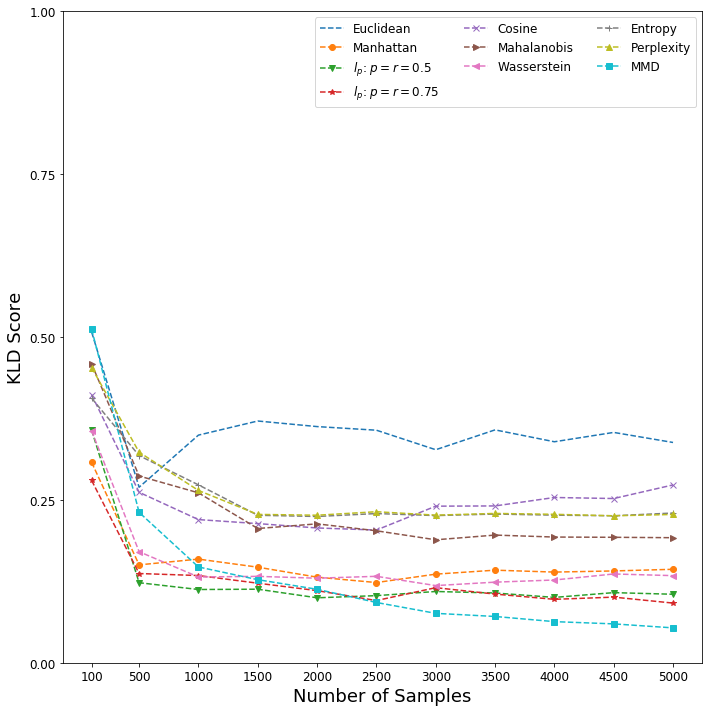

In [34]:
outdir='/home/mnewlin/git/AFIT/Thesis/code/figures/efficiency/'
markers = ['--', '--o', '--v', '--*','--x','-->','--<','--+','--^','--s','--D']
names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
#colors = ['b', 'g', 'r', 'y', 'c', 'm', 'k', ]
max_val = np.int(np.ceil(sample_eff_res_mean_df.max().max()))
"""
fig = plt.figure(figsize=(10,10))

for i in range(num_metrics):
    y_val = sample_eff_res_mean_df.iloc[i]
    sigma = sample_eff_res_std_df.iloc[i]
    plt.plot(num_sample_list, y_val, markers[i], label=sample_eff_res_mean_df.index[i])
    plt.fill_between(num_sample_list, y_val+sigma, y_val-sigma, alpha=0.1, color='b' )


plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("KLD Score", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(np.linspace(0,max_val, max_val+1), fontsize=12)
plt.legend(fontsize=12, ncol=3)

plt.tight_layout()
plt.savefig(outdir + 'eps/sample_efficiency_fft_std.pdf')
plt.savefig(outdir + 'png/sample_efficiency_fft_std.png')
plt.show()
"""
fig = plt.figure(figsize=(10,10))
for i in range(num_metrics):
    y_val = sample_eff_res_mean_df.iloc[i]
    #sigma = sample_eff_res_std_df.iloc[i]
    plt.plot(num_sample_list, y_val, markers[i], label=names[i])
    #plt.fill_between(num_sample_list, y_val+sigma, y_val-sigma, alpha=0.1, color='b' )

plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("KLD Score", fontsize=18)
plt.xticks(num_sample_list, fontsize=12)
plt.yticks(np.linspace(0,max_val, max_val+4), fontsize=12)
plt.legend(fontsize=12, ncol=3)

plt.tight_layout()
plt.savefig(outdir + 'eps/sample_efficiency_fft_no_std.pdf')
plt.savefig(outdir + 'png/sample_efficiency_fft_no_std.png')
plt.show()

## Examining Smaller Sample Sizes

### Untransformed

In [25]:
num_metrics = 10
num_sample_list = [(n+1)*100 for n in range(10)]
#num_sample_list.insert(0,100)
sample_efficiency_results = np.zeros((2, num_metrics, len(num_sample_list)))
counter = 0
for x in num_sample_list:
    # Load Sample Efficiency Results
    indir = '/run/media/mnewlin/_userdata/results_data/results/untrans/'
    real_data_untrans = pd.read_csv(indir+'real_data_exp_eff_{}.csv'.format(x)).drop(['Unnamed: 0','fid'], axis=1)
    #display(real_data_untrans.head())
    fake_data_untrans = pd.read_csv(indir+'fake_data_exp_eff_{}.csv'.format(x)).drop(['Unnamed: 0','fid'], axis=1)
    #display(fake_data_untrans.head())
    # Get mean KLD score for the 10 runs with x samples
    # Plot Number of samples vs mean KLD with standard deviation shading
    # Looking for KLD threshold of about 3
    titles = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
    labels = [r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', 
             'Metric values', 'Natural log metric values', 'Natural log Metric values', 'Natural log Metric values', 'Natural log Metric values', 'Metric values']
    subplots = []
    y_label = 'Count'
    binsize = 100
    alpha_blue = 0.8
    alpha_red = 0.6
    n_repeats = 10
    real_data = real_data_untrans
    fake_data = fake_data_untrans
    
    sample_length = x
    real_dists = np.zeros((n_repeats,binsize-1,num_metrics))
    fake_dists = np.zeros((n_repeats,binsize-1,num_metrics))

    for i in range(n_repeats):

        fig = plt.figure(figsize=(15,20))

        grid_x = 5
        grid_y = 2
        grid = mpl.gridspec.GridSpec(grid_x, grid_y)
        count = 0

        r = np.zeros((num_metrics, binsize-1))
        f = np.zeros((num_metrics, binsize-1))
        rr = 0
        rf = 0
        for j in range(grid_x):
            for k in range(grid_y):
                ax1 = plt.subplot(grid[j,k])
                if 'Natural' in labels[count]:
                    rr = np.log(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                elif '10' in labels[count]:
                    rr = np.log10(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log10(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                else:
                    rr = real_data.iloc[i*sample_length:(i+1)*sample_length, count]
                    rf = fake_data.iloc[i*sample_length:(i+1)*sample_length, count]
                best_bins_min = np.minimum(rr.min(), rf.min()) 
                best_bins_max = np.maximum(rr.max(), rf.max()) 
                bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
                real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real')
                fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake')
                r[count] = real_hist_data[0]
                f[count] = fake_hist_data[0]
                ax1.set_xlabel(labels[count], fontsize=16)
                ax1.set_ylabel(y_label, fontsize=16)
                ax1.set_title(titles[count], fontsize=16)
                ax1.legend(fontsize=16)
                count += 1
        rd = np.zeros((binsize-1, num_metrics))
        fd = np.zeros((binsize-1, num_metrics))
        for j in range(num_metrics):
            rd[:,j] = r[j]
            fd[:,j] = f[j]

        real_dists[i] = rd
        fake_dists[i] = fd 
        plt.close()
    names = ['Euclidean', 'Manhattan', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd']
    cols = []
    for i in range(n_repeats):
        cols.append('Run {}'.format(i+1))
    eps = 1e-5
    #KLD_data_all = np.zeros((num_metrics, n_repeats))
    real_data = pd.DataFrame(data=np.mean(real_dists, axis=0), columns=names)
    fake_data = pd.DataFrame(data=np.mean(fake_dists, axis=0), columns=names)
    euc_KLD = metrics.KL(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']), eps=eps)
    man_KLD = metrics.KL(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']), eps=eps)
    lp1_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']), eps=eps)
    lp2_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']), eps=eps)
    cos_KLD = metrics.KL(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']), eps=eps)
    mah_KLD = metrics.KL(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']), eps=eps)
    wass_KLD = metrics.KL(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']), eps=eps)
    ent_KLD = metrics.KL(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']), eps=eps)
    perp_KLD = metrics.KL(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']), eps=eps)
    mmd_KLD = metrics.KL(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']), eps=eps)

    kld_data = np.array([euc_KLD, man_KLD, lp1_KLD, lp2_KLD, cos_KLD, mah_KLD, wass_KLD, ent_KLD, perp_KLD, mmd_KLD])
    sample_efficiency_results[0,:,counter] = kld_data
    #sample_efficiency_results[1,:,counter] = KLD_data_untrans.loc[:,'Std. Dev.']
    counter += 1    
    #KLD_data_all[:,i] = kld_data.T
    

In [26]:
sample_eff_res_mean_df = pd.DataFrame(data=sample_efficiency_results[0], index=names, columns=num_sample_list)
display(sample_eff_res_mean_df)

,100,200,300,400,500,600,700,800,900,1000
Euclidean,0.330738,0.233228,0.227658,0.223149,0.216997,0.202199,0.205009,0.208877,0.204019,0.206896
Manhattan,0.250816,0.219203,0.206520,0.212586,0.204993,0.198470,0.196756,0.197289,0.196199,0.195095
lp: p=r=0.5,0.320453,0.256859,0.239318,0.243824,0.256819,0.209664,0.211218,0.224457,0.209546,0.218646
lp: p=r=0.75,0.323035,0.255103,0.246161,0.247345,0.247001,0.217481,0.225023,0.232648,0.218659,0.223582
cosine,2.353748,1.828871,1.986407,1.678298,1.728956,1.723458,1.642959,1.683977,1.701508,1.797143
mahalanobis,0.496372,0.341425,0.459542,0.378109,0.361185,0.374784,0.392000,0.329403,0.361950,0.345284
wasserstein,0.776848,0.550119,0.518843,0.473098,0.469808,0.474773,0.448030,0.448939,0.435321,0.443018
entropy,6.876895,7.019582,6.854274,7.038333,6.983962,7.020141,6.965812,6.919868,6.939567,6.957985
perplexity,4.879222,4.729713,4.511934,5.017885,4.712375,5.152679,5.120560,4.991881,5.022815,5.030240
mmd,0.378235,0.159141,0.160541,0.155631,0.140531,0.137877,0.137622,0.111204,0.119253,0.123355


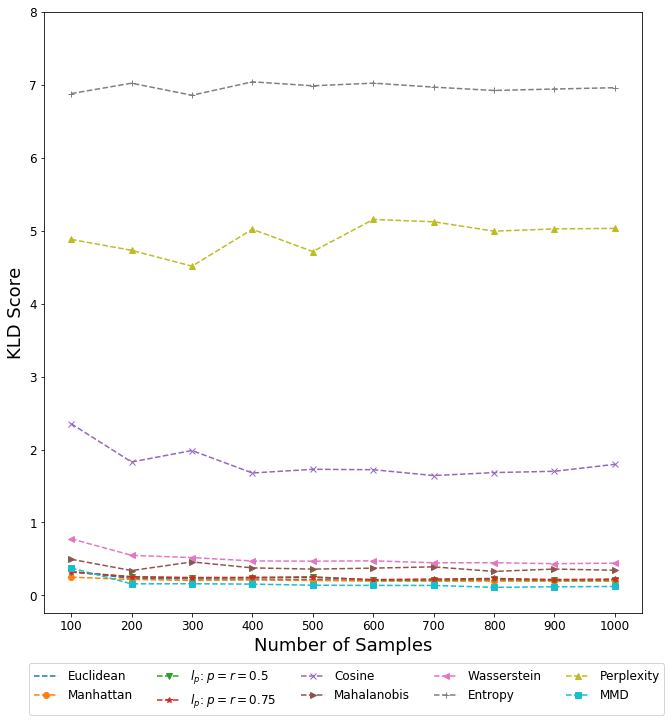

In [28]:
outdir='/home/mnewlin/git/AFIT/Thesis/code/figures/efficiency/'
markers = ['--', '--o', '--v', '--*','--x','-->','--<','--+','--^','--s','--D']
names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
#colors = ['b', 'g', 'r', 'y', 'c', 'm', 'k', ]
max_val = np.int(np.ceil(sample_eff_res_mean_df.max().max()))
fig = plt.figure(figsize=(10,10))
for i in range(num_metrics):
    y_val = sample_eff_res_mean_df.iloc[i]
    #sigma = sample_eff_res_std_df.iloc[i]
    plt.plot(num_sample_list, y_val, markers[i], label=names[i])
    #plt.fill_between(num_sample_list, y_val+sigma, y_val-sigma, alpha=0.1, color='b' )

plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("KLD Score", fontsize=18)
plt.xticks(num_sample_list, fontsize=12)
plt.yticks(np.linspace(0,max_val, max_val+1), fontsize=12)
plt.legend(loc=(-0.025,-.17), fontsize=12, ncol=5)
plt.tight_layout()

plt.savefig(outdir + 'eps/sample_efficiency_untrans_small_size.pdf')
plt.savefig(outdir + 'png/sample_efficiency_untrans_small_size.png')
plt.show()

### SQRT

In [29]:
num_metrics = 10
num_sample_list = [5*(n+1)*100 for n in range(10)]
num_sample_list.insert(0,100)
sample_efficiency_results = np.zeros((2, num_metrics, len(num_sample_list)))
counter = 0
names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
for x in num_sample_list:
    # Load Sample Efficiency Results
    indir = '/run/media/mnewlin/_userdata/results_data/results/sqrt/'
    real_data_sqrt = pd.read_csv(indir+'real_data_exp_eff_{}.csv'.format(x)).drop(['Unnamed: 0','fid'], axis=1)
    #display(real_data_untrans.head())
    fake_data_sqrt = pd.read_csv(indir+'fake_data_exp_eff_{}.csv'.format(x)).drop(['Unnamed: 0','fid'], axis=1)
    #display(fake_data_untrans.head())
    # Get mean KLD score for the 10 runs with x samples
    # Plot Number of samples vs mean KLD with standard deviation shading
    # Looking for KLD threshold of about 3
    titles = ['Manhattan', 'Euclidean', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
    labels = [r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', r'$\log_{10}$ Metric values', 
             'Metric values', 'Natural log metric values', 'Natural log Metric values', 'Natural log Metric values', 'Natural log Metric values', 'Metric values']
    subplots = []
    y_label = 'Count'
    binsize = 100
    alpha_blue = 0.8
    alpha_red = 0.6
    n_repeats = 10
    real_data = real_data_sqrt
    fake_data = fake_data_sqrt
    
    sample_length = x
    real_dists = np.zeros((n_repeats,binsize-1,num_metrics))
    fake_dists = np.zeros((n_repeats,binsize-1,num_metrics))

    for i in range(n_repeats):

        fig = plt.figure(figsize=(15,20))

        grid_x = 5
        grid_y = 2
        grid = mpl.gridspec.GridSpec(grid_x, grid_y)
        count = 0

        r = np.zeros((num_metrics, binsize-1))
        f = np.zeros((num_metrics, binsize-1))
        rr = 0
        rf = 0
        for j in range(grid_x):
            for k in range(grid_y):
                ax1 = plt.subplot(grid[j,k])
                if 'Natural' in labels[count]:
                    rr = np.log(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                elif '10' in labels[count]:
                    rr = np.log10(real_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                    rf = np.log10(fake_data.iloc[i*sample_length:(i+1)*sample_length, count]+1)
                else:
                    rr = real_data.iloc[i*sample_length:(i+1)*sample_length, count]
                    rf = fake_data.iloc[i*sample_length:(i+1)*sample_length, count]
                best_bins_min = np.minimum(rr.min(), rf.min()) 
                best_bins_max = np.maximum(rr.max(), rf.max()) 
                bins_best = np.linspace(best_bins_min, best_bins_max, binsize)
                real_hist_data = ax1.hist(rr,color='blue', bins=bins_best, alpha=alpha_blue, label='Real-Real')
                fake_hist_data = ax1.hist(rf,color='red', bins=bins_best, alpha=alpha_red, label='Real-Fake')
                r[count] = real_hist_data[0]
                f[count] = fake_hist_data[0]
                ax1.set_xlabel(labels[count], fontsize=16)
                ax1.set_ylabel(y_label, fontsize=16)
                ax1.set_title(titles[count], fontsize=16)
                ax1.legend(fontsize=16)
                count += 1
        rd = np.zeros((binsize-1, num_metrics))
        fd = np.zeros((binsize-1, num_metrics))
        for j in range(num_metrics):
            rd[:,j] = r[j]
            fd[:,j] = f[j]

        real_dists[i] = rd
        fake_dists[i] = fd 
        plt.close()
    names = ['Euclidean', 'Manhattan', 'lp: p=r=0.5', 'lp: p=r=0.75', 'cosine', 'mahalanobis', 'wasserstein', 'entropy', 'perplexity', 'mmd']
    cols = []
    for i in range(n_repeats):
        cols.append('Run {}'.format(i+1))
    eps = 1e-5
    real_data = pd.DataFrame(data=np.mean(real_dists, axis=0), columns=names)
    fake_data = pd.DataFrame(data=np.mean(fake_dists, axis=0), columns=names)
    euc_KLD = metrics.KL(real_data.loc[:,'Euclidean']/np.sum(real_data.loc[:,'Euclidean']), fake_data.loc[:,'Euclidean']/np.sum(fake_data.loc[:,'Euclidean']), eps=eps)
    man_KLD = metrics.KL(real_data.loc[:,'Manhattan']/np.sum(real_data.loc[:,'Manhattan']), fake_data.loc[:,'Manhattan']/np.sum(fake_data.loc[:,'Manhattan']), eps=eps)
    lp1_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.5']/np.sum(real_data.loc[:,'lp: p=r=0.5']), fake_data.loc[:,'lp: p=r=0.5']/np.sum(fake_data.loc[:,'lp: p=r=0.5']), eps=eps)
    lp2_KLD = metrics.KL(real_data.loc[:,'lp: p=r=0.75']/np.sum(real_data.loc[:,'lp: p=r=0.75']), fake_data.loc[:,'lp: p=r=0.75']/np.sum(fake_data.loc[:,'lp: p=r=0.75']), eps=eps)
    cos_KLD = metrics.KL(real_data.loc[:,'cosine']/np.sum(real_data.loc[:,'cosine']), fake_data.loc[:,'cosine']/np.sum(fake_data.loc[:,'cosine']), eps=eps)
    mah_KLD = metrics.KL(real_data.loc[:,'mahalanobis']/np.sum(real_data.loc[:,'mahalanobis']), fake_data.loc[:,'mahalanobis']/np.sum(fake_data.loc[:,'mahalanobis']), eps=eps)
    wass_KLD = metrics.KL(real_data.loc[:,'wasserstein']/np.sum(real_data.loc[:,'wasserstein']), fake_data.loc[:,'wasserstein']/np.sum(fake_data.loc[:,'wasserstein']), eps=eps)
    ent_KLD = metrics.KL(real_data.loc[:,'entropy']/np.sum(real_data.loc[:,'entropy']), fake_data.loc[:,'entropy']/np.sum(fake_data.loc[:,'entropy']), eps=eps)
    perp_KLD = metrics.KL(real_data.loc[:,'perplexity']/np.sum(real_data.loc[:,'perplexity']), fake_data.loc[:,'perplexity']/np.sum(fake_data.loc[:,'perplexity']), eps=eps)
    mmd_KLD = metrics.KL(real_data.loc[:,'mmd']/np.sum(real_data.loc[:,'mmd']), fake_data.loc[:,'mmd']/np.sum(fake_data.loc[:,'mmd']), eps=eps)

    kld_data = np.array([man_KLD, euc_KLD, lp1_KLD, lp2_KLD, cos_KLD, mah_KLD, wass_KLD, ent_KLD, perp_KLD, mmd_KLD])
    sample_efficiency_results[0,:,counter] = kld_data
    #sample_efficiency_results[1,:,counter] = KLD_data_untrans.loc[:,'Std. Dev.']
    counter += 1
    

In [30]:
sample_eff_res_mean_df = pd.DataFrame(data=sample_efficiency_results[0], index=names, columns=num_sample_list)
display(sample_eff_res_mean_df)

,100,500,1000,1500,2000,2500,3000,3500,4000,4500,5000
Euclidean,0.286444,0.210596,0.201744,0.183329,0.181810,0.179606,0.178948,0.180042,0.181296,0.186073,0.185084
Manhattan,0.316963,0.189103,0.162865,0.157291,0.151453,0.142382,0.151321,0.145090,0.154332,0.160467,0.162531
lp: p=r=0.5,0.333409,0.209927,0.201669,0.144756,0.160016,0.140798,0.139975,0.150677,0.155982,0.178666,0.171472
lp: p=r=0.75,0.378875,0.194720,0.184069,0.152182,0.156954,0.131010,0.137496,0.155426,0.160201,0.158442,0.157479
cosine,1.128429,0.867797,0.800906,0.764460,0.719897,0.734849,0.770793,0.789269,0.796686,0.793471,0.802304
mahalanobis,1.058204,0.703000,0.653839,0.637231,0.585846,0.614440,0.568871,0.586052,0.520220,0.577585,0.530486
wasserstein,0.565489,0.391979,0.385241,0.381118,0.392971,0.394144,0.416887,0.396489,0.411827,0.399477,0.389296
entropy,2.628473,2.617207,2.620311,2.613804,2.624881,2.604410,2.585038,2.653224,2.634571,2.653525,2.630995
perplexity,2.234848,1.786417,1.759237,1.695664,1.662180,1.521163,1.489515,1.590856,1.556106,1.499198,1.493513
mmd,0.295849,0.097530,0.078452,0.071189,0.064226,0.057917,0.041914,0.041860,0.036546,0.031298,0.029377


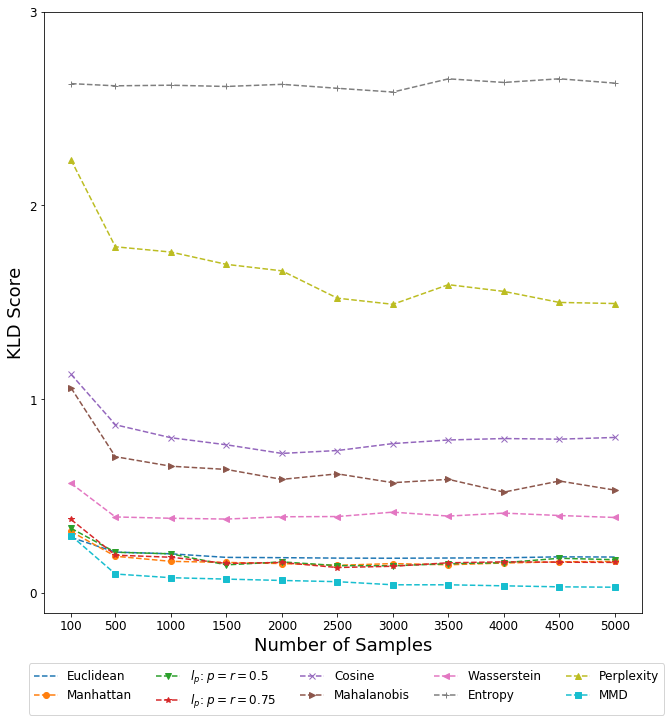

In [31]:
outdir='/home/mnewlin/git/AFIT/Thesis/code/figures/efficiency/'
markers = ['--', '--o', '--v', '--*','--x','-->','--<','--+','--^','--s','--D']
names = ['Euclidean', 'Manhattan', r'$l_p$: $p=r=0.5$', r'$l_p$: $p=r=0.75$', 'Cosine', 'Mahalanobis', 'Wasserstein', 'Entropy', 'Perplexity', 'MMD']
#colors = ['b', 'g', 'r', 'y', 'c', 'm', 'k', ]
max_val = np.int(np.ceil(sample_eff_res_mean_df.max().max()))
fig = plt.figure(figsize=(10,10))
for i in range(num_metrics):
    y_val = sample_eff_res_mean_df.iloc[i]
    #sigma = sample_eff_res_std_df.iloc[i]
    plt.plot(num_sample_list, y_val, markers[i], label=names[i])
    #plt.fill_between(num_sample_list, y_val+sigma, y_val-sigma, alpha=0.1, color='b' )

plt.xlabel("Number of Samples", fontsize=18)
plt.ylabel("KLD Score", fontsize=18)
plt.xticks(num_sample_list, fontsize=12)
plt.yticks(np.linspace(0,max_val, max_val+1), fontsize=12)
plt.legend(loc=(-0.025,-.17), fontsize=12, ncol=5)
plt.tight_layout()

plt.savefig(outdir + 'eps/sample_efficiency_sqrt_small_size.pdf')
plt.savefig(outdir + 'png/sample_efficiency_sqrt_small_size.png')
plt.show()